# **Identify commercial centers in Visakhapatnam**

### **Requirements**

Here I have used [overpy](https://pypi.org/project/overpy/), python wrapper for Overpass API to get Geo Data about Visakhapatnam City and [folium](https://pypi.org/project/folium/) for visualization purposes on Map.

In [1]:
!pip install -q folium overpy

     |████████████████████████████████| 51kB 3.2MB/s 


In [0]:
# Query Data

import overpy

api = overpy.Overpass()
res = api.query("""[out:json];
    area[name="Visakhapatnam"][boundary=administrative]->.searchArea;
    (node["amenity"](area.searchArea);
     way["amenity"](area.searchArea);
     relation["amenity"](area.searchArea);
    );
    out center;
    """)

In [0]:
# Imports

import os
import requests
import json
import pandas as pd
import numpy as np

import folium
from folium import plugins
from folium.plugins import MarkerCluster

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import DBSCAN, KMeans

In [0]:
coordinates = []
amenities = []
for node in res.nodes:
    coordinates.append((float(node.lon), float(node.lat)))
    amenities.append(node.tags['amenity'])

for way in res.ways:
    coordinates.append((float(way.center_lon), float(way.center_lat)))
    amenities.append(way.tags['amenity'])

for rel in res.relations:
    coordinates.append((float(rel.center_lon), float(rel.center_lat)))
    amenities.append(rel.tags['amenity'])

In [0]:
coordinates = np.array(coordinates)

In [6]:
len(coordinates), len(amenities)

(635, 635)

In [7]:
coordinates[0]

array([83.2812926, 17.7348024])

## **Plots**

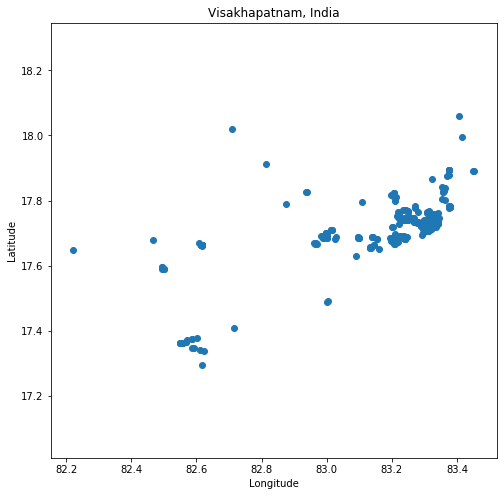

In [8]:
plt.figure(figsize=(8, 8))
plt.scatter(coordinates[:, 0], coordinates[:, 1])
plt.title('Visakhapatnam, India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

From the graph above we can understand that the areas with dense-ly clustered points are more developed and has many amenities as compared to areas with far away points. There areas might be underdeveloped or there may be natural areas such as mountains or lakes.

In [0]:
map_ = folium.Map([float(node.lat), float(node.lon)], zoom_start=4.4)

In [0]:
for node in res.nodes:
    folium.CircleMarker([float(node.lat), float(node.lon)], radius=5,
                         popup=node.tags['amenity'], fill_color='r').add_to(map_)

for way in res.ways:
    folium.CircleMarker([float(way.center_lat), float(way.center_lon)], radius=5,
                         popup=way.tags['amenity'], fill_color='r').add_to(map_)
    
for rel in res.relations:
    folium.CircleMarker([float(rel.center_lat), float(rel.center_lon)], radius=5,
                         popup=rel.tags['amenity'], fill_color='r').add_to(map_)

In [0]:
# Saving interactive map to hard-disk
map_.save('map_with_markers.html')

In [0]:
lat_lons = []
for node in res.nodes:
    lat_lons.append((float(node.lat), float(node.lon)))

for way in res.ways:
    lat_lons.append((float(way.center_lat), float(way.center_lon)))

for rel in res.relations:
    lat_lons.append((float(rel.center_lat), float(rel.center_lon)))

lat_lons = np.array(lat_lons)

In [0]:
map_heatmap = map_.add_child(plugins.HeatMap(lat_lons, radius=20))

In [0]:
# Saving Heat-map to hard-disk
map_heatmap.save('map_heatmap.html')

# **Clustering**

## Density Based Spatial Clustering of Application with Noise (**DBSCAN**)

DBSCAN is a well-known data clustering algorithm that is commonly used in data mining and machine learning.

Based on a set of points, DBSCAN groups together points that are close to each other based on a distance measurement (usually Euclidean distance) and a minimum number of points. It also marks as outliers the points that are in low-density regions.

To identify the commercial centers, I have performed clustering using DBSCAN.


In [0]:
db = DBSCAN(eps=0.05, min_samples=3).fit(coordinates)
labels = db.labels_

In [16]:
set(labels)

{-1, 0, 1, 2, 3, 4}

In [0]:
color_pallete = [
    'darkpurple',
    'green',
    'lightgreen',
    'lightred',
    'orange',
    'darkgreen',
    'yellow',
    'darkblue',
    'red',
    'lightblue',
    'pink',
    'cadetblue',
    'lightgray'
]

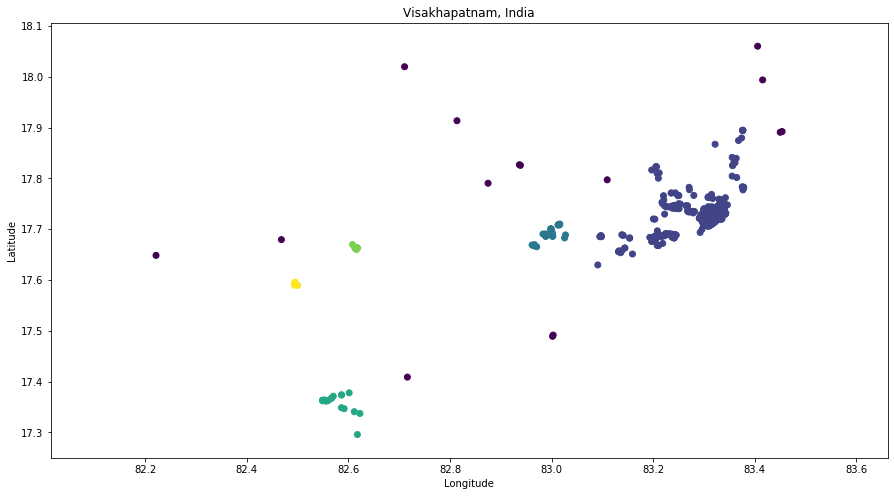

In [18]:
plt.figure(figsize=(15, 8))
plt.scatter(coordinates[:,0], coordinates[:,1], c=db.labels_.astype(float))
plt.title('Visakhapatnam, India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

DBSCAN has identified 6 clusters from the entire data

In [0]:
map_ = folium.Map([coordinates[0][1], coordinates[0][0]], zoom_start=4.4)

In [0]:
for i, coord in enumerate(coordinates):
    folium.CircleMarker(location=[coord[1], coord[0]], radius = 6, popup=amenities[i],
                            fill=True, fill_color=color_pallete[labels[i]],
                            color=color_pallete[labels[i]]).add_to(map_)

In [0]:
# Save interactive map to Hard-Disk
map_.save('map_dbscan_clusters.html')

## **K-Means** Clustering

k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster.

To identify the commercial centers, I have performed clustering using K-Means.

Identifying the correct "K" is important before directly performing K-means clustering. Therefore I performed the Elbow-method to find out the best "K"


### Elbow Method

In [0]:
from scipy.cluster.vq import kmeans, vq
from scipy.spatial.distance import cdist

k = range(1, 20)
KM = [kmeans(coordinates, k_) for k_ in k]
centroids = [cent for (cent, var) in KM]

D_k = [cdist(coordinates, cent, 'euclidean') for cent in centroids]

c_index = [np.argmin(d, axis=1) for d in D_k]
dist = [np.min(d, axis=1) for d in D_k]
avg_within_ss = [sum(d)/coordinates.shape[0] for d in dist]

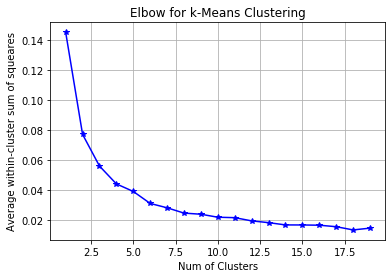

In [23]:
# k_index = 2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k, avg_within_ss, "b*-")
# ax.plot(k[k_index], avg_within_ss[k_index], marker='o', markersize=12,
#         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Num of Clusters')
plt.ylabel('Average within-cluster sum of squeares')
tt = plt.title('Elbow for k-Means Clustering')

From the graph above we can see that the graph is smooth, so identifying the correct "K" is not simple. Therefore I have used "Silhouette Score Analysis" for finding the best "K".

### Silhouette Score Analysis

Num Clusters: 2, Silhoutte Score: 0.8451626244951492
Num Clusters: 3, Silhoutte Score: 0.7321900273650067
Num Clusters: 4, Silhoutte Score: 0.7372603848877789
Num Clusters: 5, Silhoutte Score: 0.6140046956609959
Num Clusters: 6, Silhoutte Score: 0.6511251680912102
Num Clusters: 7, Silhoutte Score: 0.6501459344411175
Num Clusters: 8, Silhoutte Score: 0.6470581980611636
Num Clusters: 9, Silhoutte Score: 0.6528816406534577
Num Clusters: 10, Silhoutte Score: 0.6586596740921183
Num Clusters: 11, Silhoutte Score: 0.6751281465412412
Num Clusters: 12, Silhoutte Score: 0.5248264100208292
Num Clusters: 13, Silhoutte Score: 0.5284934574620519
Num Clusters: 14, Silhoutte Score: 0.5300425437215353
Num Clusters: 15, Silhoutte Score: 0.6755077947310446
Num Clusters: 16, Silhoutte Score: 0.544768396375465
Num Clusters: 17, Silhoutte Score: 0.5473021018386938
Num Clusters: 18, Silhoutte Score: 0.5396672788842527
Num Clusters: 19, Silhoutte Score: 0.513162664083182


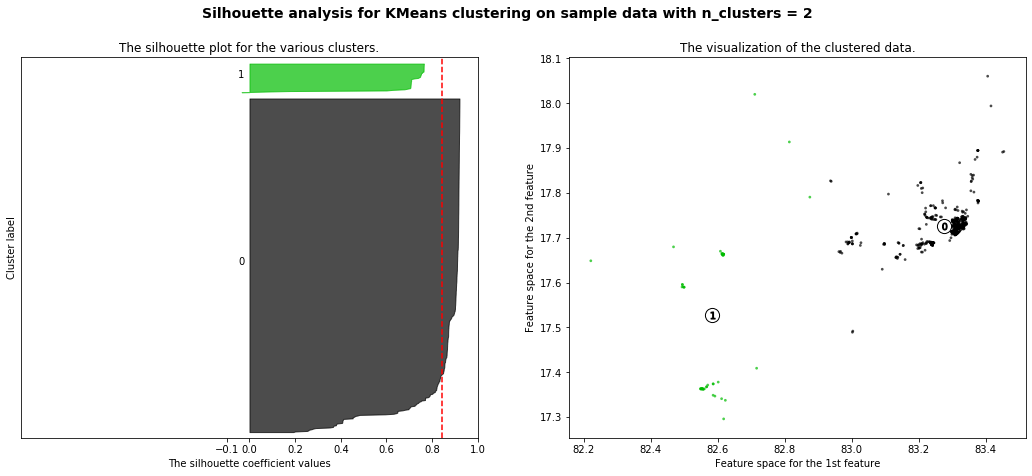

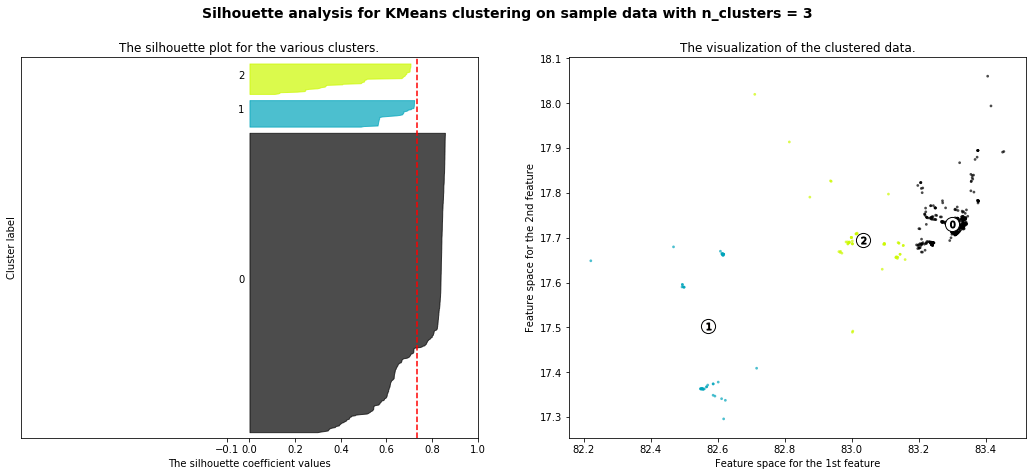

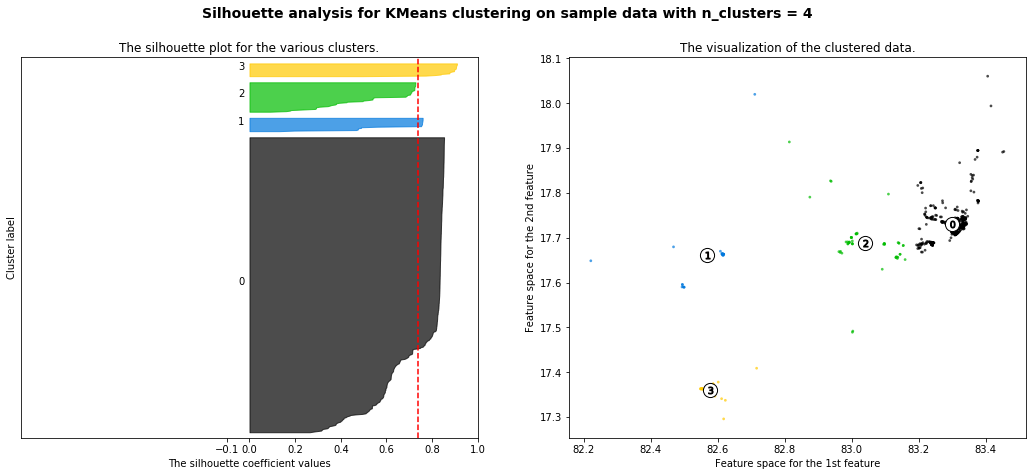

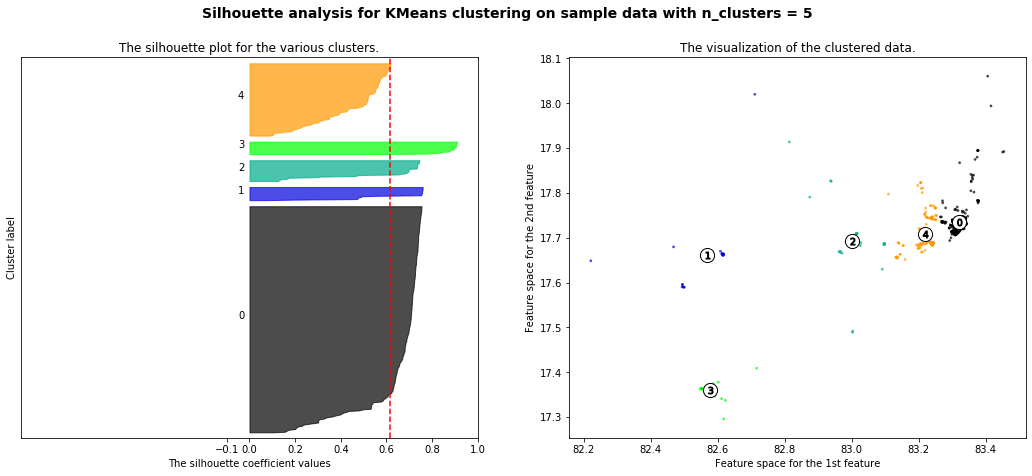

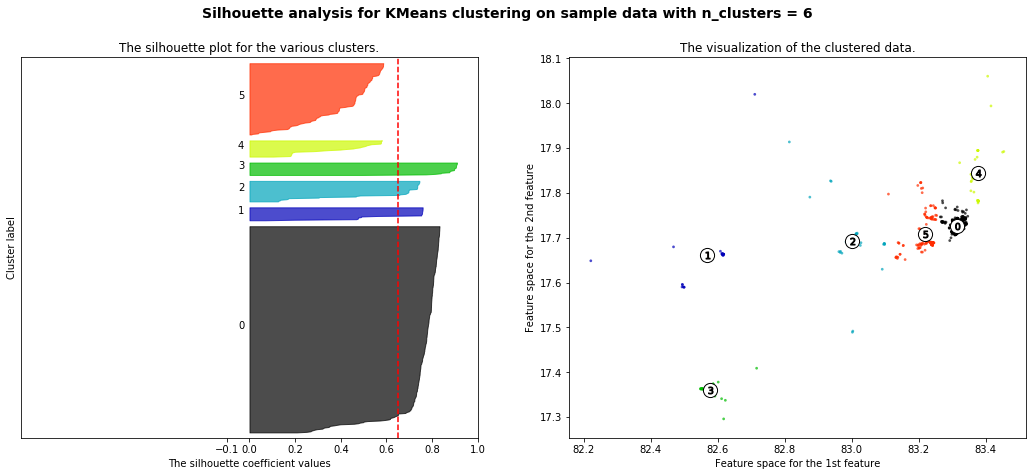

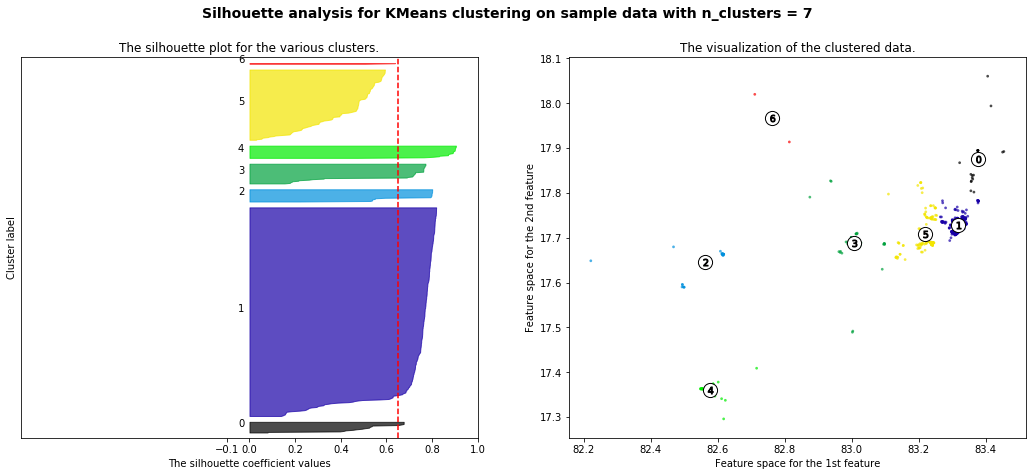

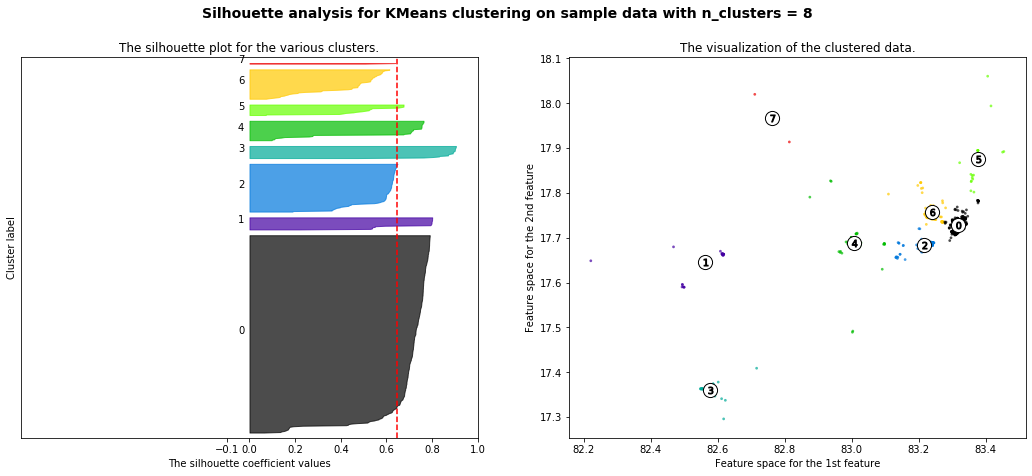

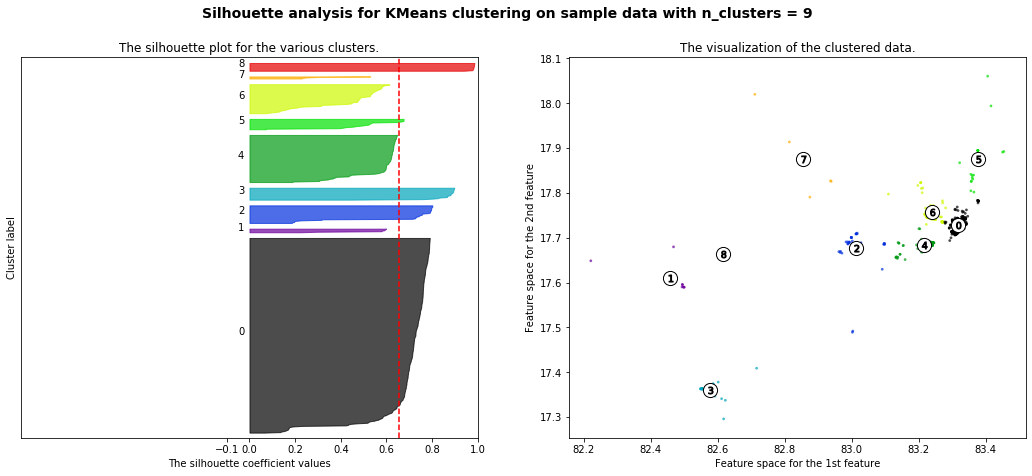

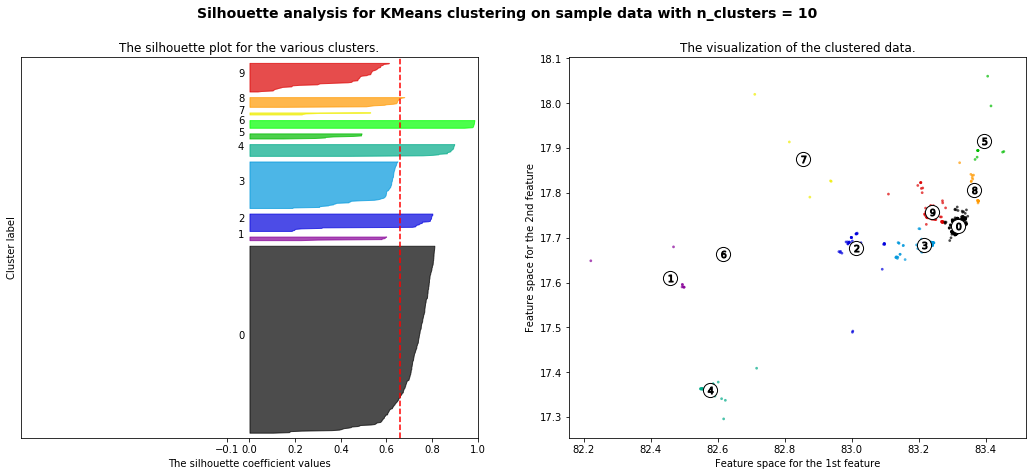

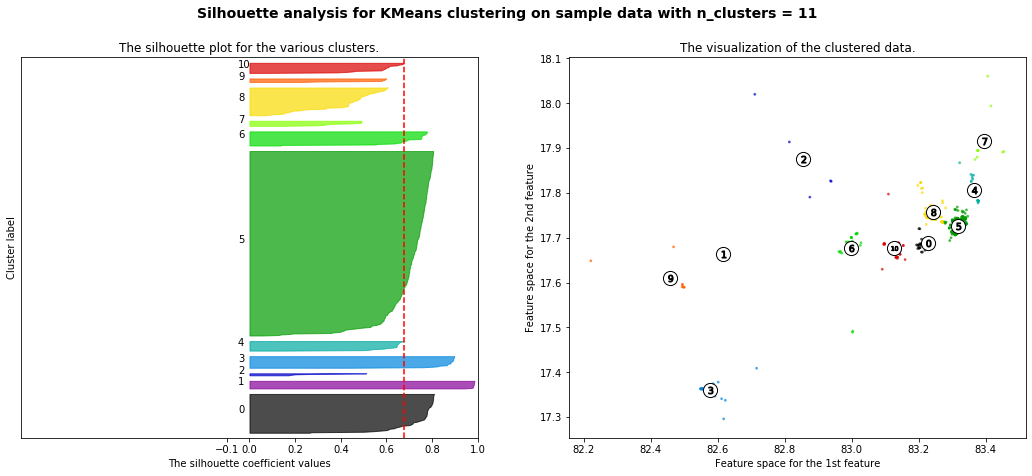

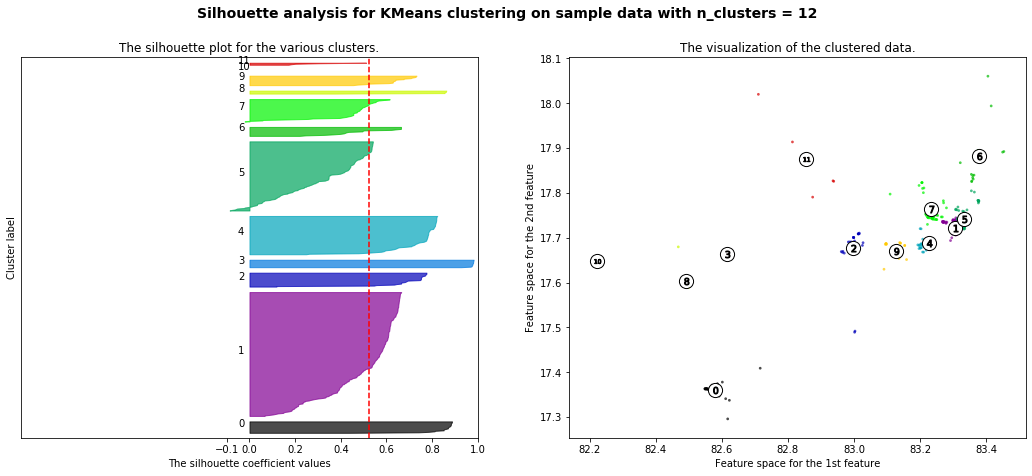

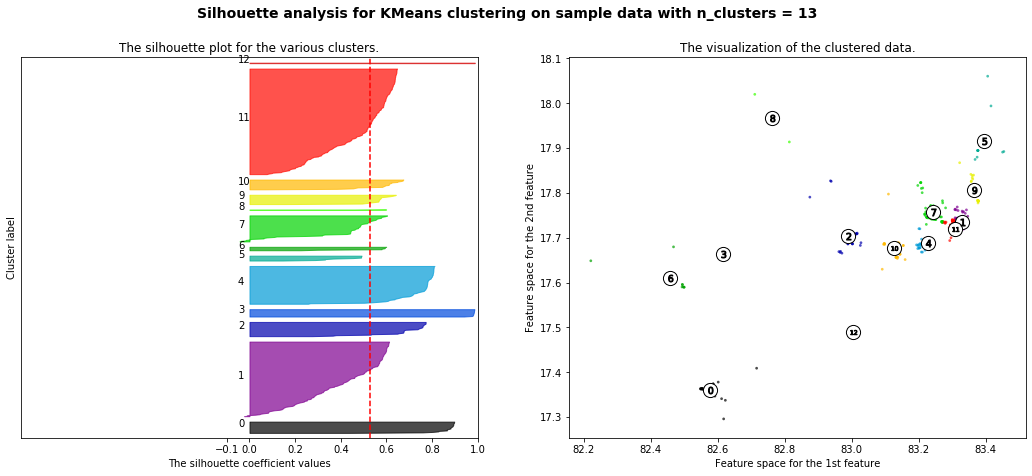

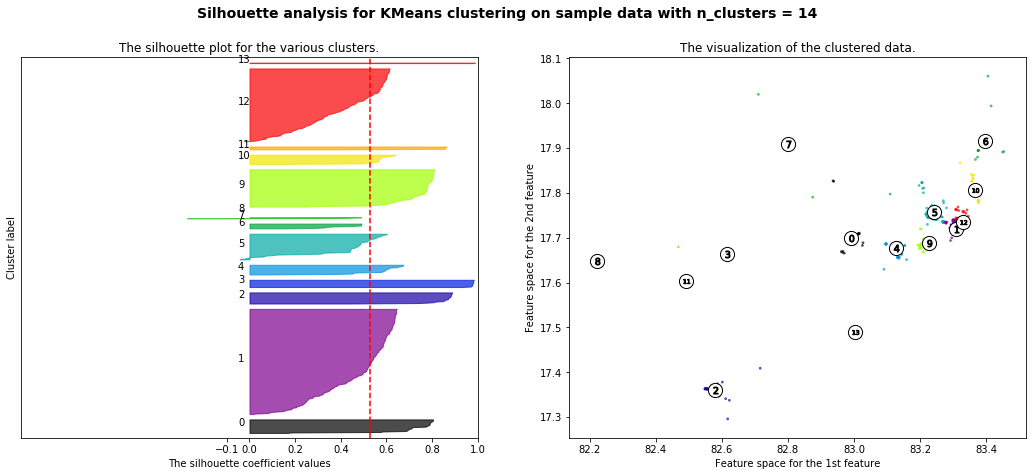

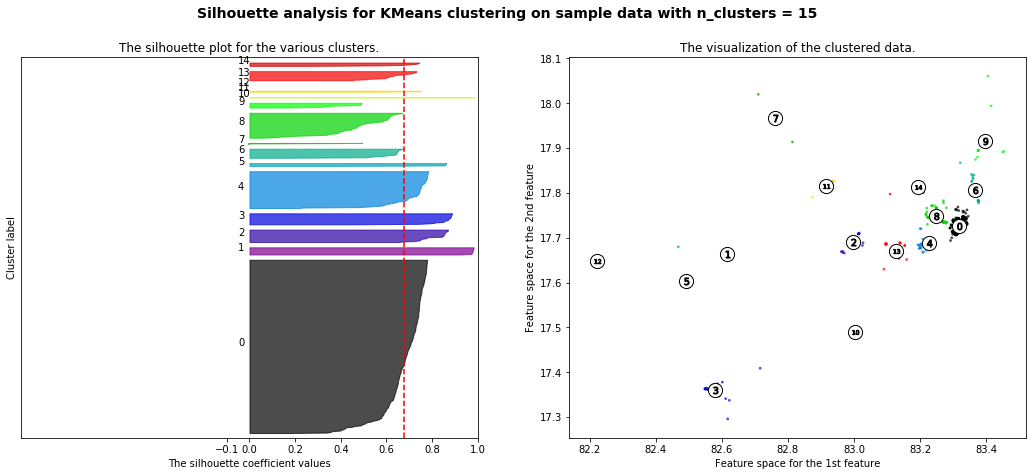

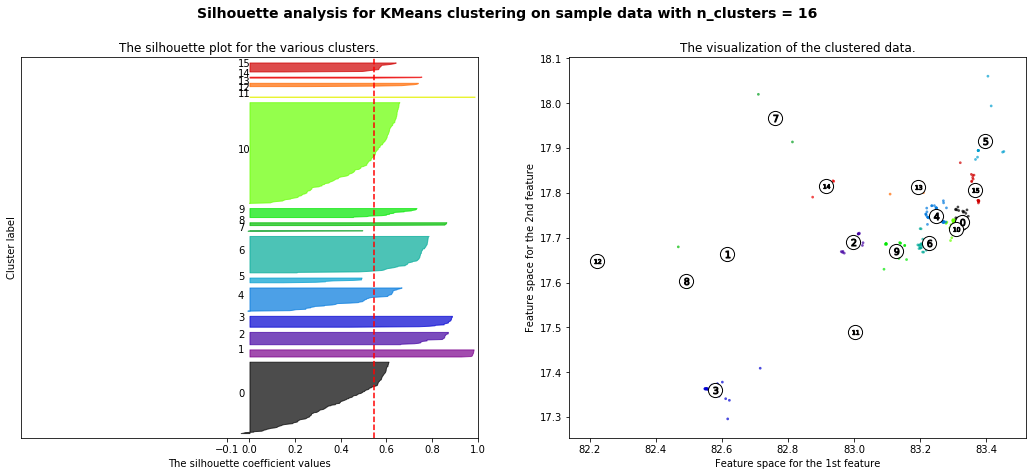

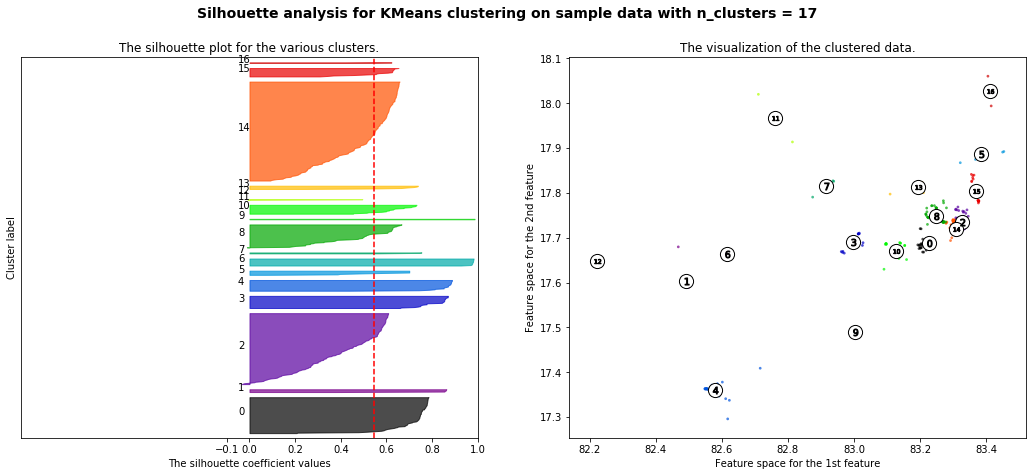

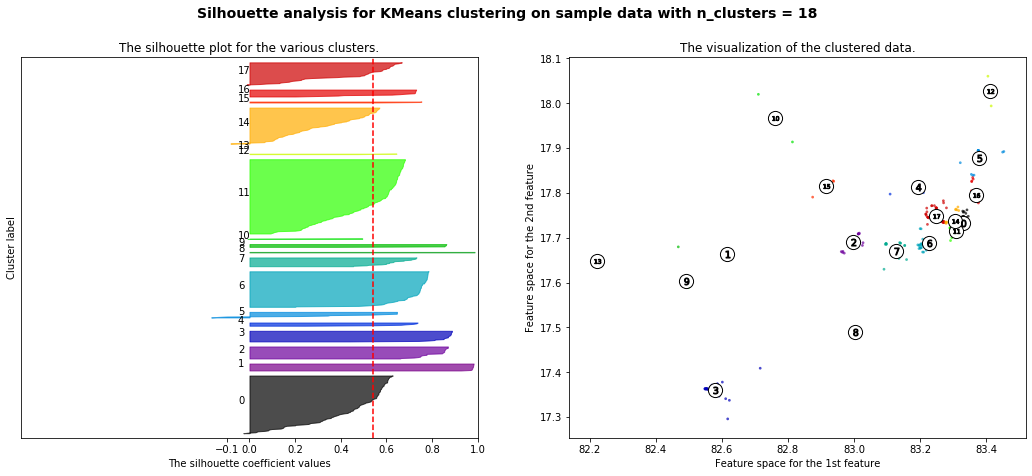

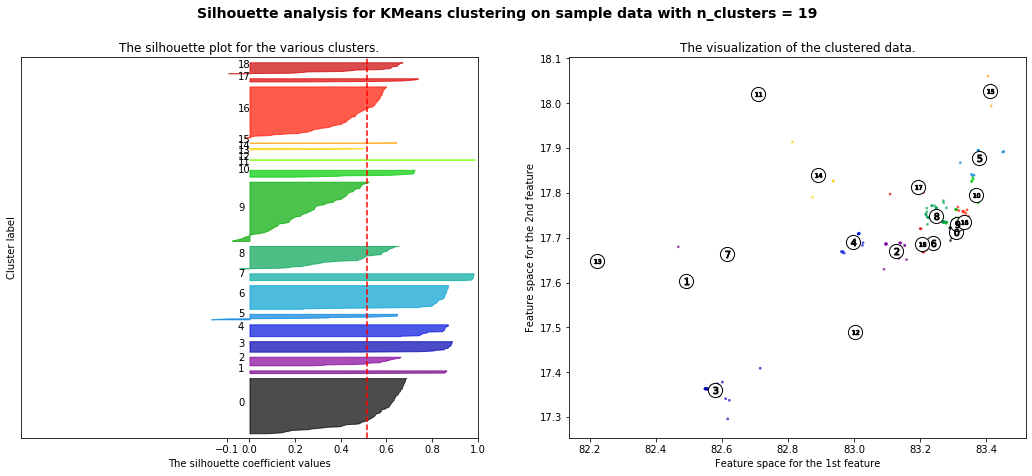

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

k = range(2, 20)

for k_ in k:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(coordinates) + (k_ + 1)*10])

    clusterer = KMeans(n_clusters=k_, random_state=10)
    cluster_labels = clusterer.fit_predict(coordinates)

    silhouette_avg = silhouette_score(coordinates, cluster_labels)
    print('Num Clusters: {}, Silhoutte Score: {}'.format(k_, silhouette_avg))

    sample_silhouette_values = silhouette_samples(coordinates, cluster_labels)

    y_lower = 10
    for i in range(k_):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k_)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / k_)

    ax2.scatter(coordinates[:, 0], coordinates[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k_),
                 fontsize=14, fontweight='bold')
plt.show()

From the above analysis we can infer that the data is complex. Either a cluster is very small or the silhouette score of cluster-member is fairly below the average silhouette score of cluster.

In [0]:
km = KMeans(n_clusters=5).fit(coordinates)
labels = km.labels_

In [26]:
set(labels)

{0, 1, 2, 3, 4}

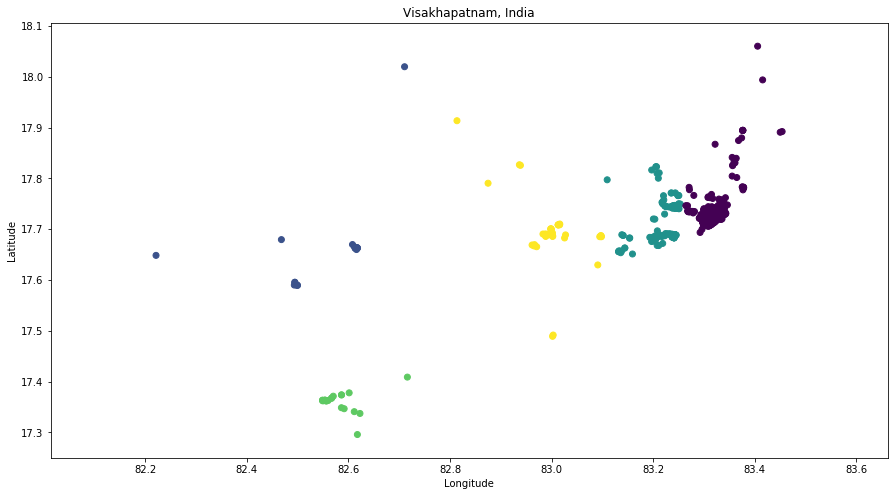

In [27]:
plt.figure(figsize=(15, 8))
plt.scatter(coordinates[:,0], coordinates[:,1], c=km.labels_.astype(float))
plt.title('Visakhapatnam, India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [0]:
map_ = folium.Map([coordinates[0][1], coordinates[0][0]], zoom_start=4.4)

In [0]:
for i, coord in enumerate(coordinates):
    # print(color_pallete[labels[i]])
    folium.CircleMarker(location=[coord[1], coord[0]], radius=6, popup=amenities[i],
                            fill=True, fill_color=color_pallete[labels[i]],
                            color=color_pallete[labels[i]]).add_to(map_)

In [0]:
map_.save('map_kmeans_clustering.html')

## Understanding the Data

As we have observed that achieving good clustering on a large data is not always possible and can lead to improper clusters. Therefore, we zoom into one of the larger clusters and repeat the process again and see if we can infer some insights and obtain better clusters.

In [0]:
l_lon = 83.27
h_lon = 83.37
l_lat = 17.7
h_lat = 17.8

filt_coords = []
filt_coords += [(float(node.lon), float(node.lat))
            for node in res.nodes if l_lon<=node.lon<=h_lon and l_lat<=node.lat<=h_lat]
filt_coords += [(float(way.center_lon), float(way.center_lat))
           for way in res.ways if l_lon<=way.center_lon<=h_lon and l_lat<=way.center_lat<=h_lat]
filt_coords += [(float(rel.center_lon), float(rel.center_lat))
           for rel in res.relations if l_lon<=rel.center_lon<=h_lon and l_lat<=rel.center_lat<=h_lat]

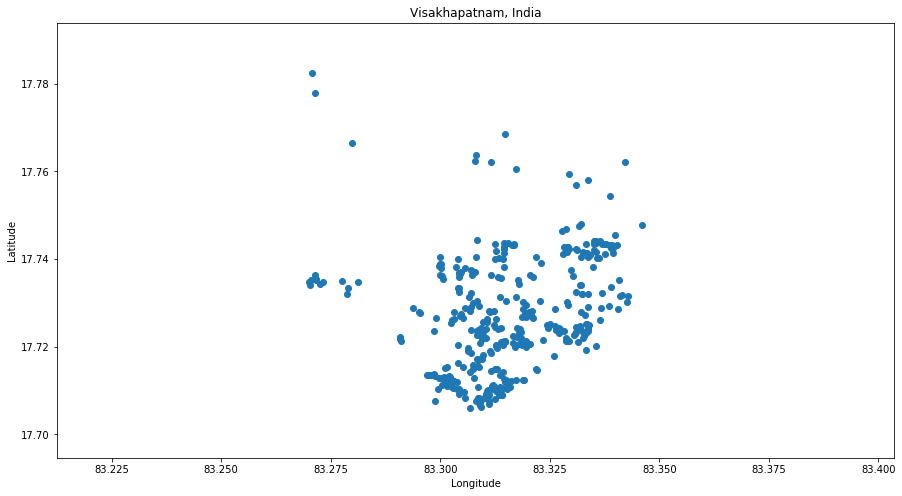

In [32]:
X = np.array(filt_coords)

plt.figure(figsize=(15, 8))
plt.scatter(X[:,0], X[:,1])
plt.title('Visakhapatnam, India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

## DBSCAN Clustering

In [33]:
clustering = DBSCAN(eps=0.005, min_samples=2).fit(X)
labels = clustering.labels_
set(labels)

{-1, 0, 1, 2, 3, 4, 5}

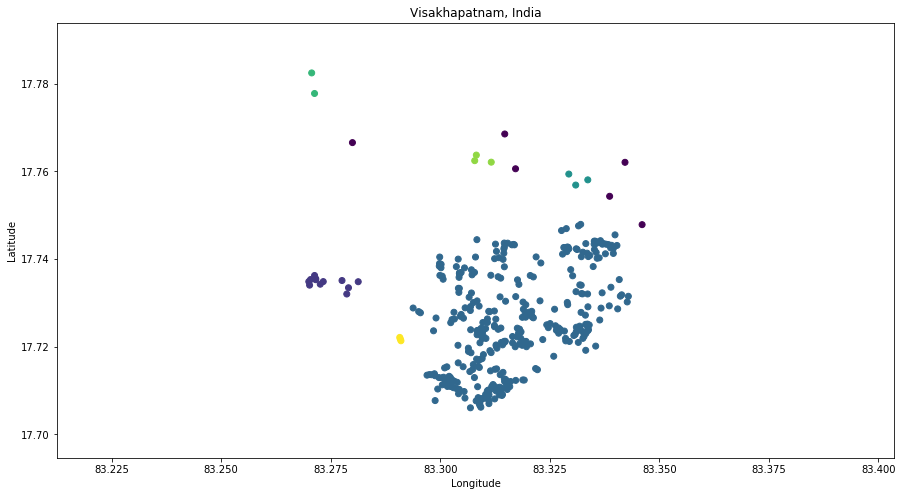

In [34]:
plt.figure(figsize=(15, 8))
plt.scatter(X[:,0], X[:,1], c=clustering.labels_.astype(float))
plt.title('Visakhapatnam, India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

DBSCAN has identified 7 clusters

In [0]:
map_ = folium.Map([coordinates[0][1], coordinates[0][0]], zoom_start=4.4)

In [0]:
for i, coord in enumerate(X):
    folium.CircleMarker(location=[coord[1], coord[0]], radius = 6, popup=amenities[i],
                            fill=True, fill_color=color_pallete[labels[i]],
                            color=color_pallete[labels[i]]).add_to(map_)

In [0]:
map_.save('map_dbscan_clusters_smaller.html')

## K-Means Clustering

### Elbow method

In [0]:
from scipy.cluster.vq import kmeans, vq
from scipy.spatial.distance import cdist

k = range(1, 20)
KM = [kmeans(X, k_) for k_ in k]
centroids = [cent for (cent, var) in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

c_index = [np.argmin(d, axis=1) for d in D_k]
dist = [np.min(d, axis=1) for d in D_k]
avg_within_ss = [sum(d)/X.shape[0] for d in dist]

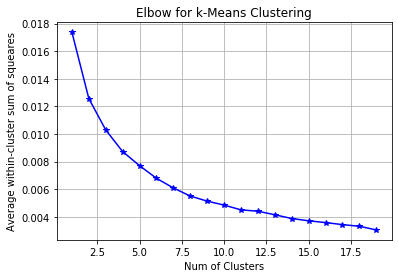

In [39]:
# k_index = 2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k, avg_within_ss, "b*-")
# ax.plot(k[k_index], avg_within_ss[k_index], marker='o', markersize=12,
#         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Num of Clusters')
plt.ylabel('Average within-cluster sum of squeares')
tt = plt.title('Elbow for k-Means Clustering')

### Silhouette Score Analysis

Num Clusters: 2, Silhoutte Score: 0.4314644906076116
Num Clusters: 3, Silhoutte Score: 0.45514642608317546
Num Clusters: 4, Silhoutte Score: 0.4445733004815891
Num Clusters: 5, Silhoutte Score: 0.45738456952103884
Num Clusters: 6, Silhoutte Score: 0.4363089647872555
Num Clusters: 7, Silhoutte Score: 0.4589546746851135
Num Clusters: 8, Silhoutte Score: 0.470698069853044
Num Clusters: 9, Silhoutte Score: 0.4690881513136999
Num Clusters: 10, Silhoutte Score: 0.4789890456646059
Num Clusters: 11, Silhoutte Score: 0.4742735005734895
Num Clusters: 12, Silhoutte Score: 0.47706129238262707
Num Clusters: 13, Silhoutte Score: 0.4857711748914525
Num Clusters: 14, Silhoutte Score: 0.48982574491683617
Num Clusters: 15, Silhoutte Score: 0.4859438974301074
Num Clusters: 16, Silhoutte Score: 0.4767467741024816
Num Clusters: 17, Silhoutte Score: 0.4878900866819327
Num Clusters: 18, Silhoutte Score: 0.4709176553418645
Num Clusters: 19, Silhoutte Score: 0.48616271655059023


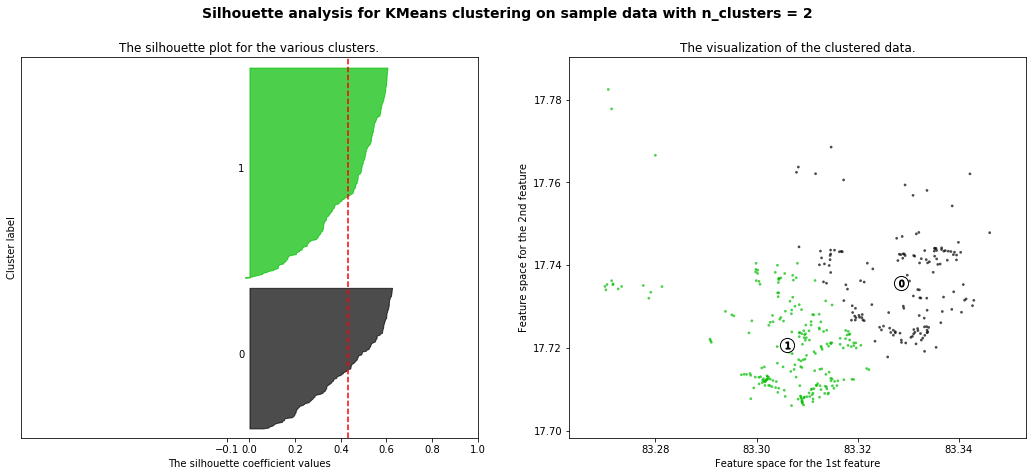

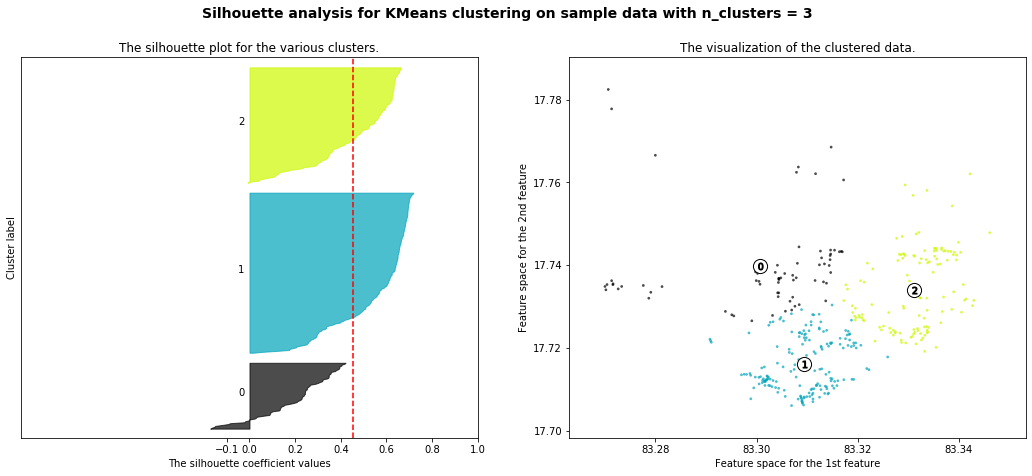

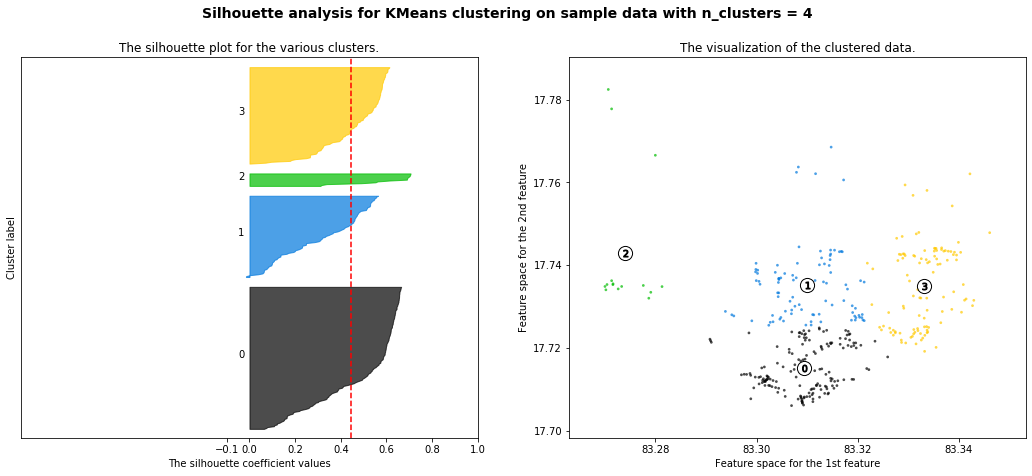

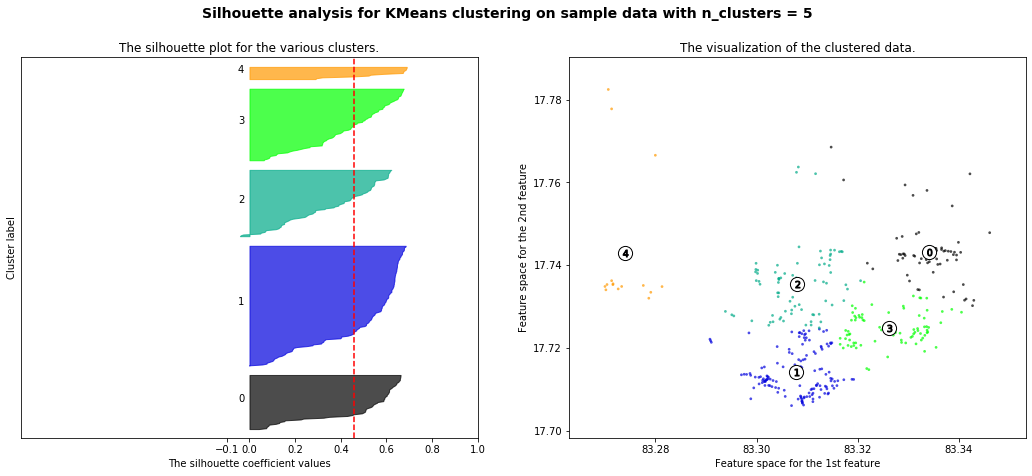

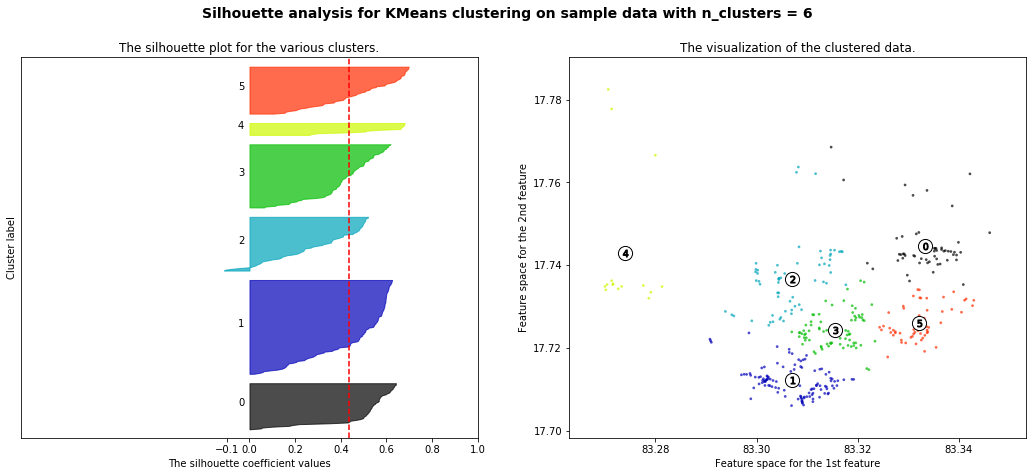

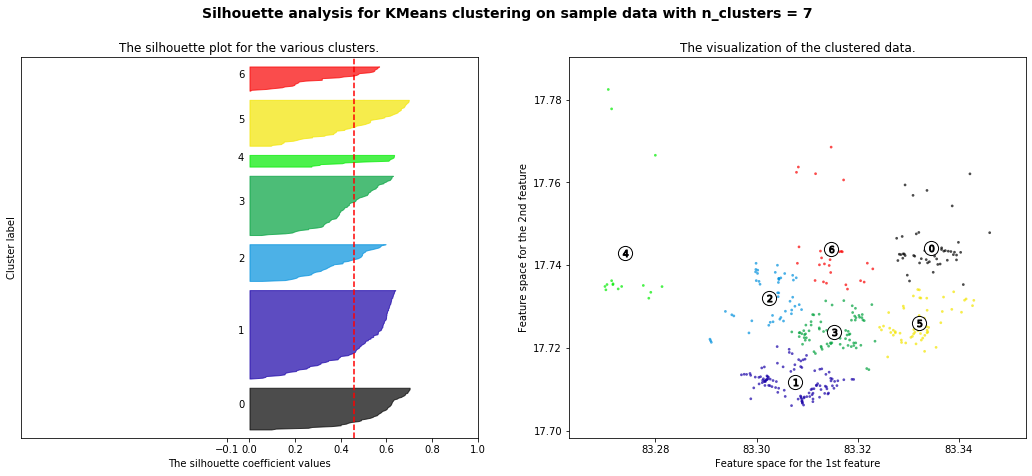

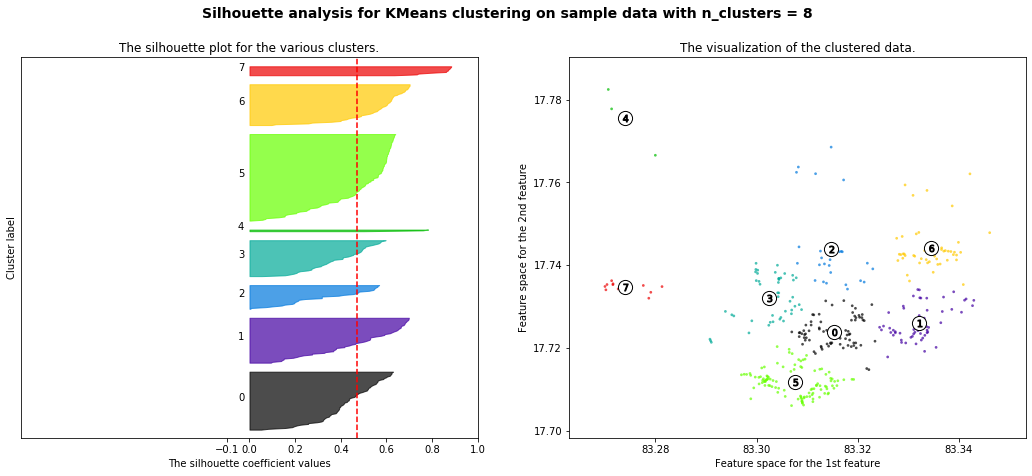

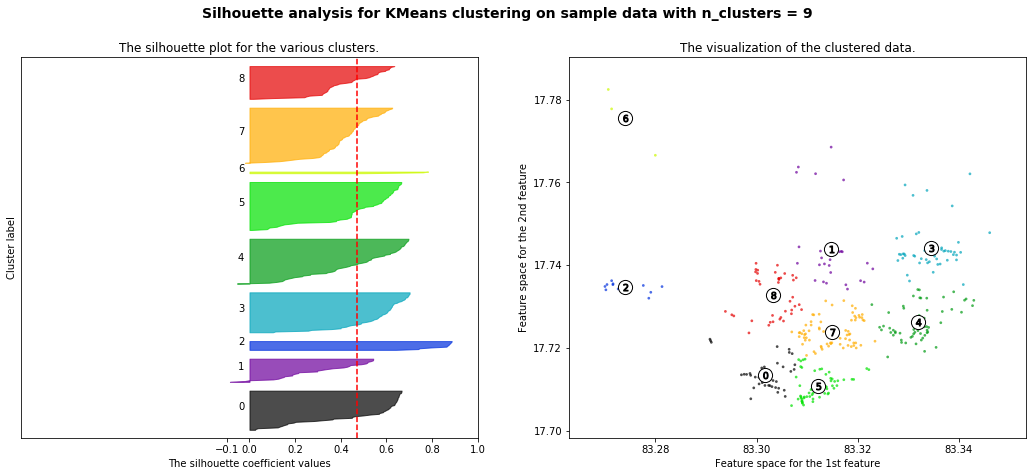

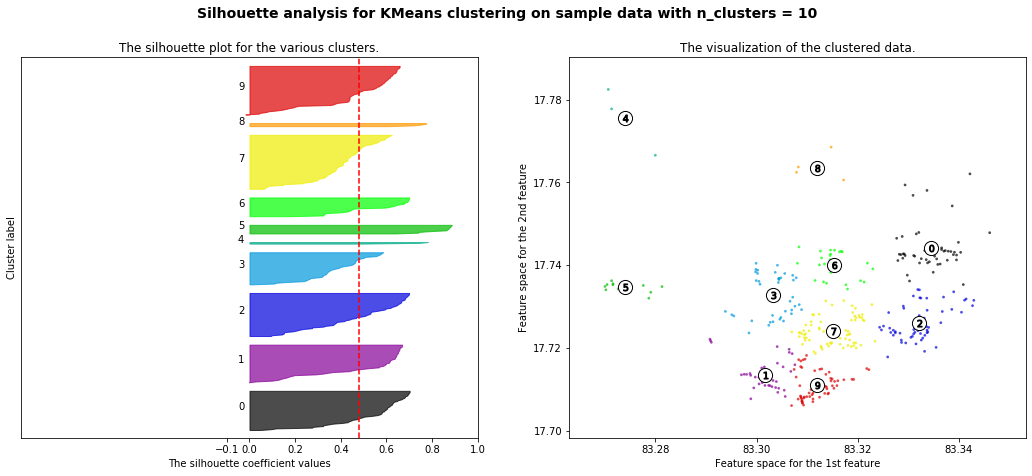

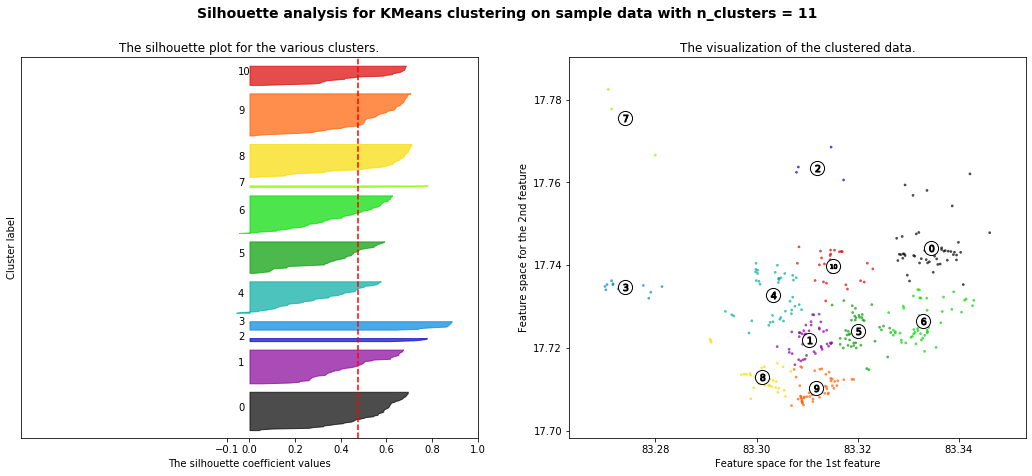

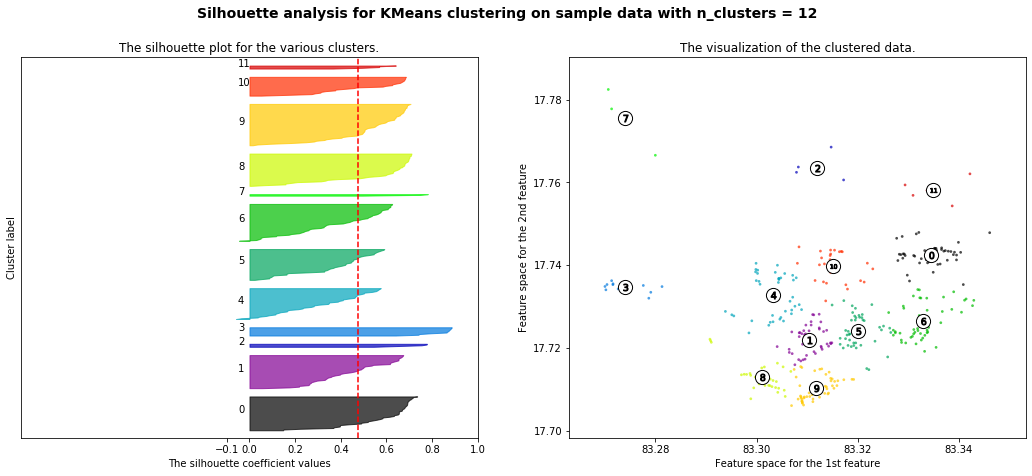

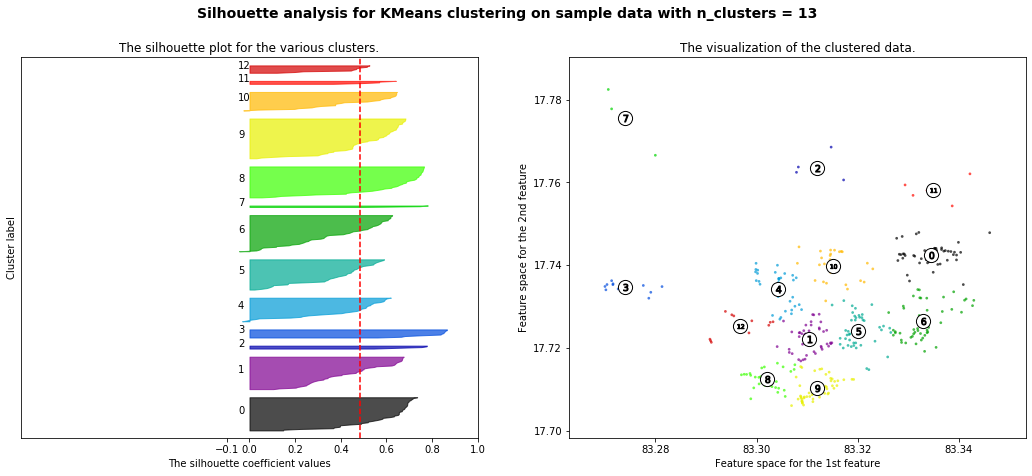

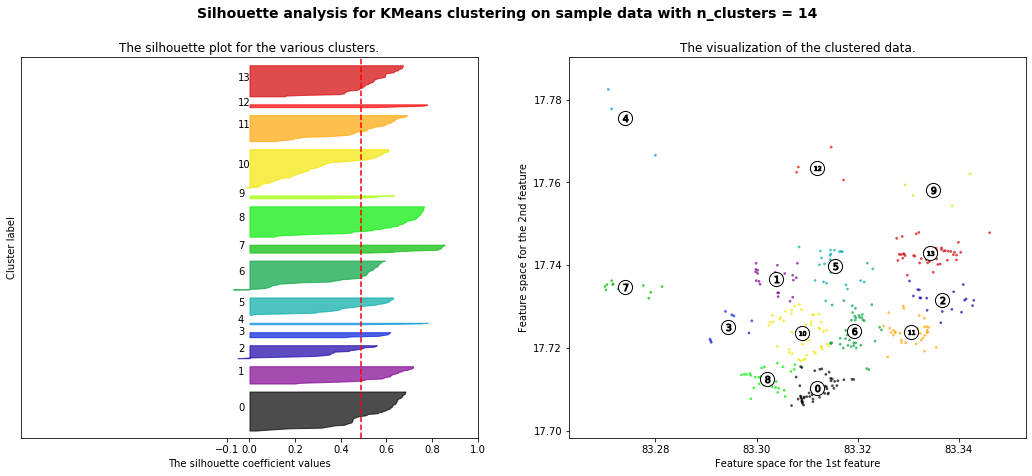

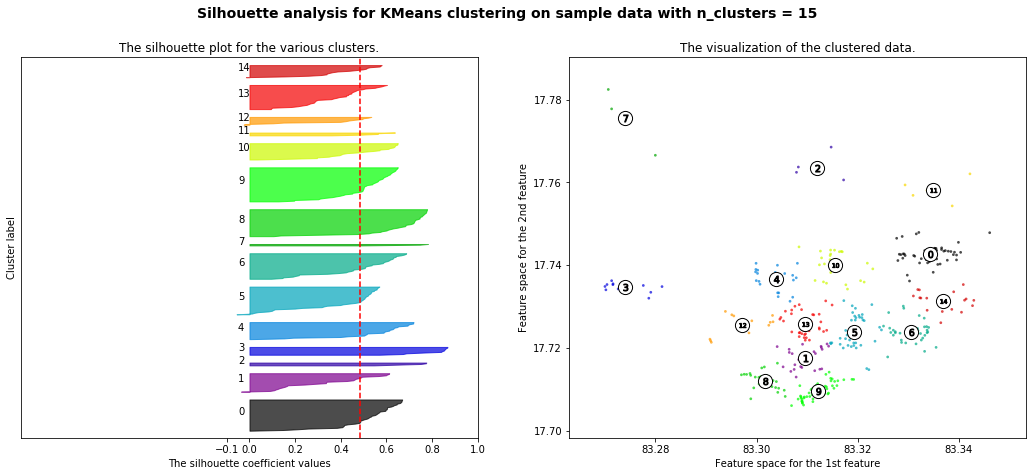

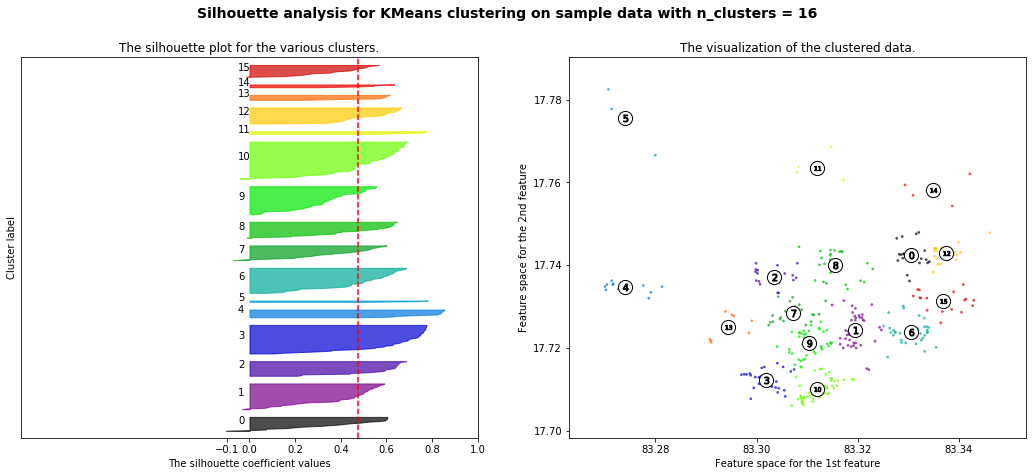

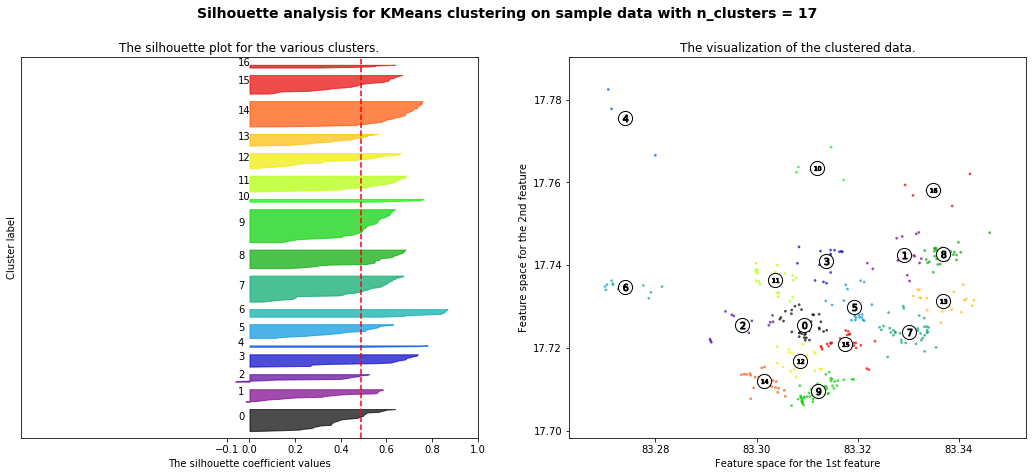

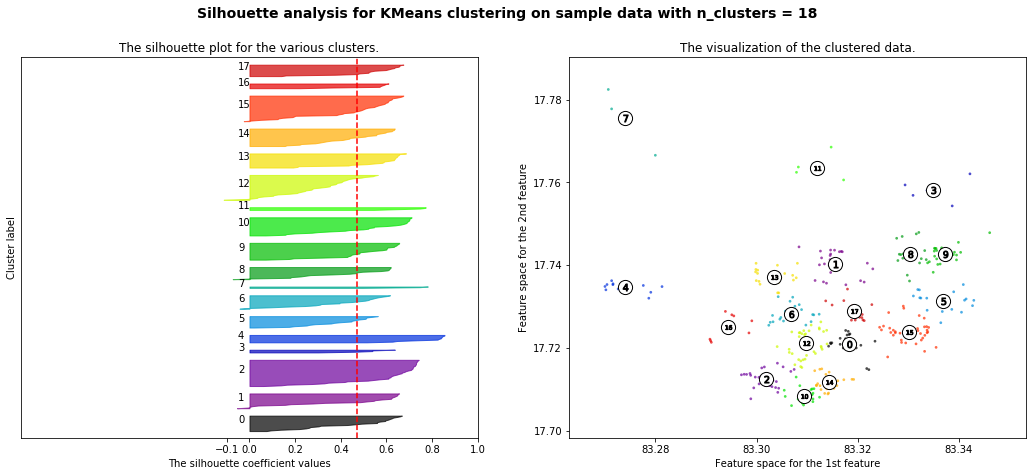

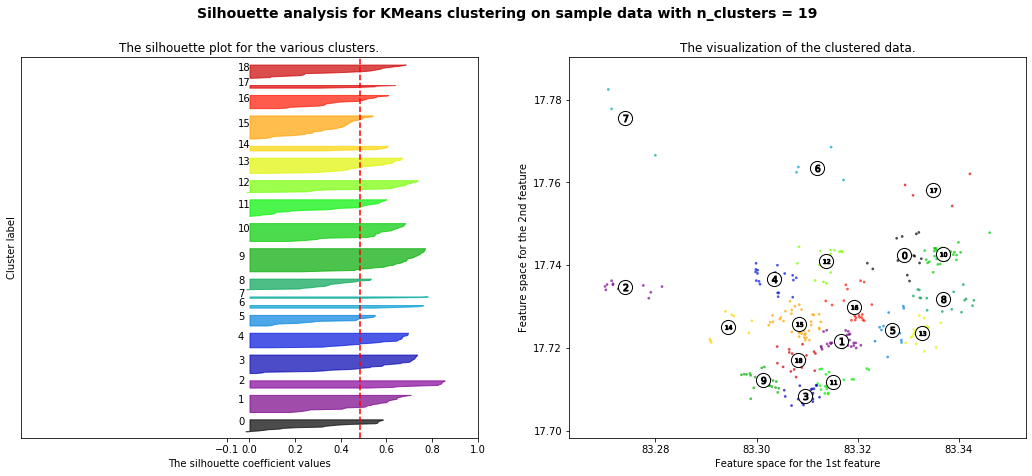

In [40]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

k = range(2, 20)

for k_ in k:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (k_ + 1)*10])

    clusterer = KMeans(n_clusters=k_, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print('Num Clusters: {}, Silhoutte Score: {}'.format(k_, silhouette_avg))

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(k_):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k_)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / k_)

    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k_),
                 fontsize=14, fontweight='bold')
plt.show()

In [0]:
km = KMeans(n_clusters=7).fit(X)
labels = km.labels_

In [42]:
set(labels)

{0, 1, 2, 3, 4, 5, 6}

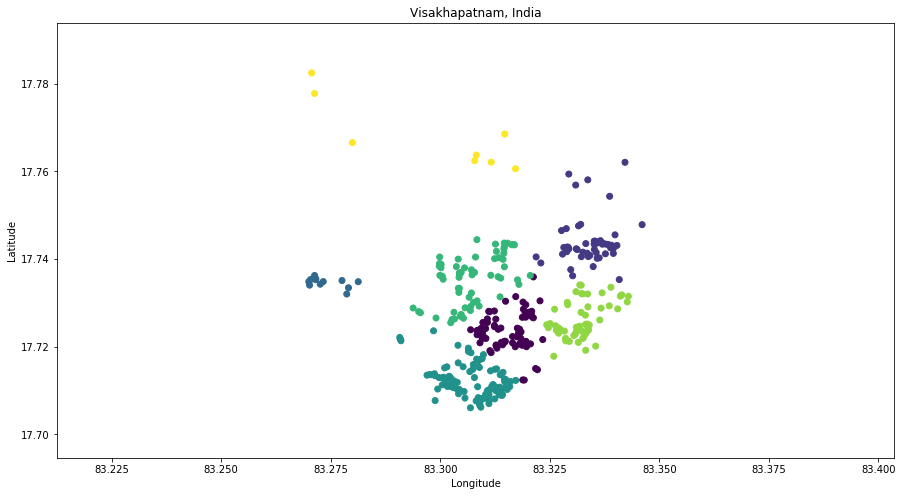

In [43]:
plt.figure(figsize=(15, 8))
plt.scatter(X[:,0], X[:,1], c=km.labels_.astype(float))
plt.title('Visakhapatnam, India')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

As we can observe the plot, we have identified the above 7 clusters.

In [0]:
map_ = folium.Map([X[0][1], X[0][0]], zoom_start=4.4)

In [0]:
for i, coord in enumerate(X):
    # print(color_pallete[labels[i]])
    folium.CircleMarker(location=[coord[1], coord[0]], radius=6, popup=amenities[i],
                            fill=True, fill_color=color_pallete[labels[i]],
                            color=color_pallete[labels[i]]).add_to(map_)

In [0]:
map_.save('map_kmeans_clustering_smaller.html')